## Gait Video Study 
### Traditional ML algorithms on 2 task generalization frameworks, namely a) W-> WT b) VBW-> VBWT, to classify HOA/MS/PD strides and subjects 
#### Remember to add the original count of frames in a single stride (before down sampling via smoothing) for each stride as an additional artificial feature to add information about speed of the subject to the model

1. Save the optimal hyperparameters, confusion matrices and ROC curves for each algorithm.
2. Make sure to not use x, y, z, confidence = 0, 0, 0, 0 as points for the model since they are simply missing values and not data points, so make sure to treat them before inputting to model 
3. Make sure to normalize (z-score normalization) the features before we feed them to the model.
4. We use the summary statistics as range, CoV and asymmetry between the right and left limbs as the features to input to the traditional models requiring fixed size 1D input for each training/testing set sample.
5. Since we are implementating "pure" task generalization, we train and test on exactly same subjects i.e. we only retain common subjects across W and WT for a) and only retain common subjects across VBW and VBWT for b).


In [1]:
# 33 subject in total (~10 per group) 
# 4500 strides - 2000 strides - 200 groups for 10 strides per group
# STRIDE - 20*36 - MEAN SUBSTRACTION --- BATCH NORM. 
# 90 features - 36 Cov, 36 Range, 18 assymetry, 18 DEN
# Z-SCORE 
# Default + Dimensionality reduction - 3D space
# Try top 10 features 
# Subject generalization is where the overfitting issue is tested - If we get good results, that means we are not 
# overfitting 

#Check how is AUC 1 even when accurcay is low?

In [2]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import task_gen_traditionalML
reload(task_gen_traditionalML)
from ml_utils.task_gen_traditionalML import keep_subjects_common_across_train_test, normalize, models, evaluate
from ml_utils.task_gen_traditionalML import plot_ROC

In [3]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\MLresults\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())

#Whether to save the results (confusion matrices and RoC plots) or not 
save_results = True 

,key,cohort,trial,scenario,video,PID,stride_number,frame_count,label,right hip-x-CoV,...,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
0,GVS_212_T_T1_1,HOA,BW,SLWT,GVS_212_T_T1,212,1,46,0,0.046077,...,14.426173,3.407379,10.662441,0.830365,0.502570,31.450487,8.644012,5.236678,31.182183,8.215725
1,GVS_212_T_T1_2,HOA,BW,SLWT,GVS_212_T_T1,212,2,39,0,0.021528,...,1.360847,5.155307,11.363806,4.333776,1.025647,28.266400,2.671081,6.678294,15.058825,4.903579
2,GVS_212_T_T1_3,HOA,BW,SLWT,GVS_212_T_T1,212,3,56,0,0.034394,...,1.341021,8.625363,7.159495,3.366152,1.759968,17.545787,5.921325,8.243491,9.578638,3.008162
3,GVS_212_T_T1_4,HOA,BW,SLWT,GVS_212_T_T1,212,4,53,0,0.028511,...,2.375934,6.728268,0.098235,0.999027,0.541911,7.843339,4.279617,0.748023,19.471731,5.086056
4,GVS_212_T_T1_5,HOA,BW,SLWT,GVS_212_T_T1,212,5,44,0,0.025213,...,8.525816,1.775282,0.033210,9.166863,1.354601,6.674183,8.479480,4.373622,0.315168,11.795593


### main() 

### Task generalization framework 1: train on walking (W) and test on walking while talking (WT) to classify HOA/MS/PD strides and subjects 

In [4]:
#Trial W for training 
trialW = data[data['scenario']=='W']
#Trial WT for testing 
trialWT = data[data['scenario']=='WT']

#Trial W and WT after making sure both training and testing sets have common subjects 
trialW_reduced, trialWT_reduced = keep_subjects_common_across_train_test(trialW, trialWT)
# print ('Number of subjects in training and test sets after reduction:', len(trialW_reduced['PID'].unique()), \
#            len(trialWT_reduced['PID'].unique()))
print ('Training set (trial W):', trialW_reduced.groupby(['cohort'])['PID'].value_counts())
print ('Testing set (trial WT):', trialWT_reduced.groupby(['cohort'])['PID'].value_counts())
cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the training stride data
trialW_reduced = shuffle(trialW_reduced, random_state = 0)
trainX = trialW_reduced.drop(cols_to_drop, axis = 1)
trainY = trialW_reduced[['PID', 'label']]
print ('Training shape', trainX.shape, trainY.shape)

#Shuffling the testing stride data 
trialWT_reduced = shuffle(trialWT_reduced, random_state = 0)
testX = trialWT_reduced.drop(cols_to_drop, axis = 1)
testY = trialWT_reduced[['PID', 'label']] #PID to compute person based metrics later 
print ('Testing shape', testX.shape, testY.shape)

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(trainX, 'z')
trainX_norm = (trainX-norm_mean)/norm_sd
testX_norm = (testX-norm_mean)/norm_sd

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(trialW_reduced))
print ('HOA, MS and PD strides in training set:\n', trialW_reduced['cohort'].value_counts())

#Test Set
print('\nStrides in test set: ', len(trialWT_reduced)) 
print ('HOA, MS and PD strides in test set:\n', trialWT_reduced['cohort'].value_counts())
print ('Imbalance ratio (controls:MS:PD)= 1:X:Y\n', trialWT_reduced['cohort'].value_counts()/trialWT_reduced['cohort'].value_counts()['HOA'])

framework = 'WtoWT' #Defining the task generalization framework of interest

Original number of subjects in training and test sets: 32 26
Subjects in test set, which are not in training set
[403]
Subjects in training set, which are not in test set
[312, 102, 112, 113, 115, 123, 124]
Number of subjects in training and test sets after reduction: 25 25
Training set (trial W): cohort  PID
HOA     215    45
        218    45
        212    44
        213    43
        216    40
        219    40
        217    39
        214    38
MS      320    45
        311    43
        310    41
        322    40
        323    40
        321    39
        313    38
        314    38
        318    17
PD      406    44
        408    44
        409    44
        404    41
        405    41
        410    41
        407    39
        411    39
Name: PID, dtype: int64
Testing set (trial WT): cohort  PID
HOA     217    47
        212    46
        213    45
        218    45
        215    44
        219    44
        216    42
        214    38
MS      320    47
        323    47

In [6]:
trialW.columns

Index(['key', 'cohort', 'trial', 'scenario', 'video', 'PID', 'stride_number',
       'frame_count', 'label', 'right hip-x-CoV', 'right hip-y-CoV',
       'right hip-z-CoV', 'right knee-x-CoV', 'right knee-y-CoV',
       'right knee-z-CoV', 'right ankle-x-CoV', 'right ankle-y-CoV',
       'right ankle-z-CoV', 'left hip-x-CoV', 'left hip-y-CoV',
       'left hip-z-CoV', 'left knee-x-CoV', 'left knee-y-CoV',
       'left knee-z-CoV', 'left ankle-x-CoV', 'left ankle-y-CoV',
       'left ankle-z-CoV', 'left toe 1-x-CoV', 'left toe 1-y-CoV',
       'left toe 1-z-CoV', 'left toe 2-x-CoV', 'left toe 2-y-CoV',
       'left toe 2-z-CoV', 'left heel-x-CoV', 'left heel-y-CoV',
       'left heel-z-CoV', 'right toe 1-x-CoV', 'right toe 1-y-CoV',
       'right toe 1-z-CoV', 'right toe 2-x-CoV', 'right toe 2-y-CoV',
       'right toe 2-z-CoV', 'right heel-x-CoV', 'right heel-y-CoV',
       'right heel-z-CoV', 'right hip-x-range', 'right hip-y-range',
       'right hip-z-range', 'right knee-x-range', '

In [4]:
trialW['PID'].unique()

array([212, 213, 214, 215, 216, 217, 218, 219, 310, 311, 312, 313, 314,
       318, 320, 321, 322, 323, 404, 405, 406, 407, 408, 409, 410, 411,
       102, 112, 113, 115, 123, 124], dtype=int64)

In [5]:
# ml_models = ['logistic_regression']
ml_models = ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  \
             'linear_svm', 'mlp']
metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 

#For storing predicted probabilities for person (for all classes HOA/MS/PD) to show ROC curves 
predicted_probs_person = pd.DataFrame(columns = [ml_model + cohort for ml_model in ml_models for cohort in ['_HOA', '_MS', '_PD'] ]) 

logistic_regression
Stride-based model performance (Macro):  0.7795275590551181 0.783083460435621 0.7781255150733063 0.7781961603260857 0.911542459289001
Stride-based model performance (Micro):  0.7795275590551181 0.7795275590551181 0.7795275590551181 0.7795275590551181 None
Stride-based model performance (Weighted):  0.7795275590551181 0.7823036991939775 0.7795275590551181 0.7784783609010044 0.9116939490673601
Stride-based model performance (Class-wise):  0.7795275590551181 [0.7382716  0.76870748 0.84227129] [0.85185185 0.68072289 0.8018018 ] [0.79100529 0.72204473 0.82153846] None
LogisticRegression(random_state=0)
Person-based model performance (Macro):  0.92 0.9333333333333332 0.9259259259259259 0.9212962962962964 1.0
Person-based model performance (Micro):  0.92 0.92 0.92 0.92 None
Person-based model performance (Weighted):  0.92 0.9359999999999999 0.92 0.9194444444444446 1.0
Person-based model performance (Class-wise):  0.92 [0.8 1.  1. ] [1.         0.77777778 1.        ] [0.888

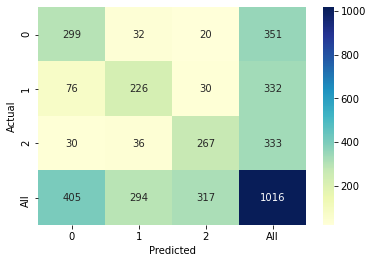

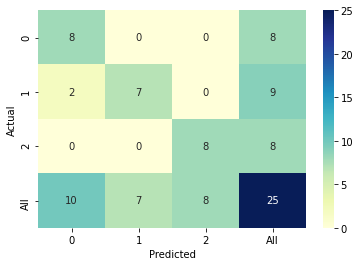

********************************
random_forest
Stride-based model performance (Macro):  0.5866141732283464 0.5927851131290812 0.5851908442269887 0.5858181751785531 0.823495181928917
Stride-based model performance (Micro):  0.5866141732283464 0.5866141732283464 0.5866141732283464 0.5866141732283464 None
Stride-based model performance (Weighted):  0.5866141732283464 0.5919954555624465 0.5866141732283464 0.5860928966035569 0.8234826149042067
Stride-based model performance (Class-wise):  0.5866141732283464 [0.54352941 0.50847458 0.72635135] [0.65811966 0.45180723 0.64564565] [0.59536082 0.4784689  0.6836248 ] None
RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=0.05, n_estimators=50, random_state=0)
Person-based model performance (Macro):  0.56 0.5714285714285715 0.5648148148148148 0.5642701525054465 0.8184317129629629
Person-based model performance (Micro):  0.56 0.56 0.56 0.56 None
Person-based model performance (Weighted):  0.56 0.56

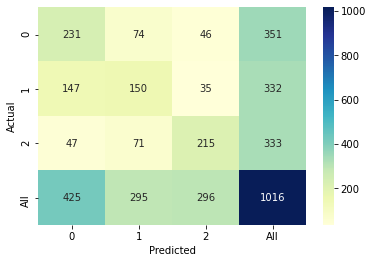

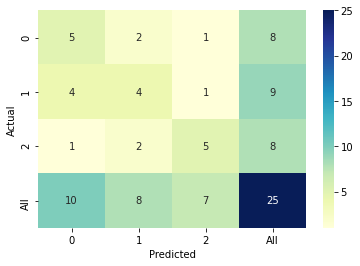

********************************
adaboost
Stride-based model performance (Macro):  0.5167322834645669 0.5312096457153928 0.5142165644173676 0.5179920933122423 0.7068372950233727
Stride-based model performance (Micro):  0.5167322834645669 0.5167322834645669 0.5167322834645669 0.5167322834645669 None
Stride-based model performance (Weighted):  0.5167322834645669 0.5317582992411877 0.5167322834645669 0.5195356022631953 0.7081236619698045
Stride-based model performance (Class-wise):  0.5167322834645669 [0.55097087 0.32947977 0.71317829] [0.64672365 0.34337349 0.55255255] [0.59501966 0.33628319 0.62267343] None
AdaBoostClassifier(learning_rate=0.01, n_estimators=100, random_state=0)
Person-based model performance (Macro):  0.56 0.5797619047619048 0.5648148148148148 0.5709064327485379 0.695023148148148
Person-based model performance (Micro):  0.56 0.56 0.56 0.56 None
Person-based model performance (Weighted):  0.56 0.5725714285714285 0.56 0.5649122807017544 0.6911111111111111
Person-based mo

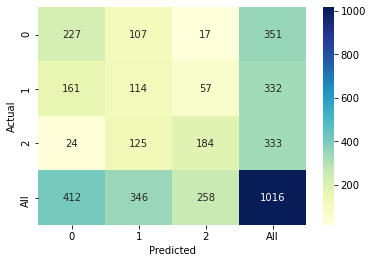

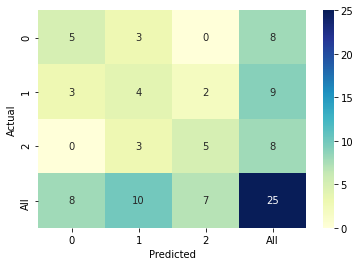

********************************
kernel_svm
Stride-based model performance (Macro):  0.6456692913385826 0.6519568256989223 0.6454167327661303 0.6473899889500692 0.8509482176371957
Stride-based model performance (Micro):  0.6456692913385826 0.6456692913385826 0.6456692913385826 0.6456692913385826 None
Stride-based model performance (Weighted):  0.6456692913385826 0.6514435114868298 0.6456692913385826 0.6472712734113142 0.8508430309300128
Stride-based model performance (Class-wise):  0.6456692913385826 [0.61930295 0.58571429 0.75085324] [0.65811966 0.61746988 0.66066066] [0.63812155 0.60117302 0.7028754 ] None
SVC(gamma=0.001, probability=True, random_state=0)
Person-based model performance (Macro):  0.76 0.7662337662337663 0.7546296296296297 0.7555555555555555 0.8935185185185185
Person-based model performance (Micro):  0.76 0.76 0.76 0.76 None
Person-based model performance (Weighted):  0.76 0.7646753246753246 0.76 0.7573333333333332 0.8926388888888888
Person-based model performance (Cl

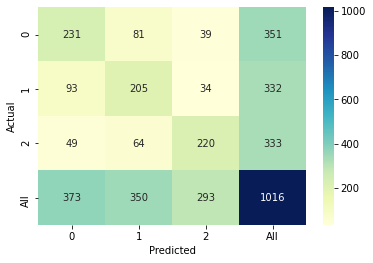

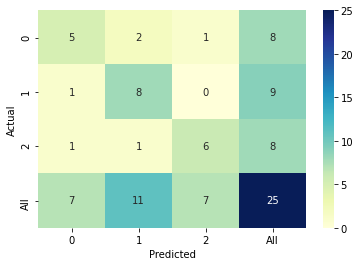

********************************
gbm
Stride-based model performance (Macro):  0.8248031496062992 0.833635165155291 0.8233260291493224 0.8241818182792047 0.9451761856938118
Stride-based model performance (Micro):  0.8248031496062992 0.8248031496062992 0.8248031496062992 0.8248031496062992 None
Stride-based model performance (Weighted):  0.8248031496062992 0.8321613384782046 0.8248031496062992 0.8241404199923391 0.9451351071394236
Stride-based model performance (Class-wise):  0.8248031496062992 [0.75059382 0.83629893 0.91401274] [0.9002849  0.70783133 0.86186186] [0.81865285 0.76672104 0.88717156] None
GradientBoostingClassifier(max_depth=4, max_features=5, min_samples_leaf=3,
                           n_estimators=150, random_state=0)
Person-based model performance (Macro):  0.96 0.9629629629629629 0.9629629629629629 0.9607843137254902 1.0
Person-based model performance (Micro):  0.96 0.96 0.96 0.96 None
Person-based model performance (Weighted):  0.96 0.9644444444444444 0.96 0.96 1.0


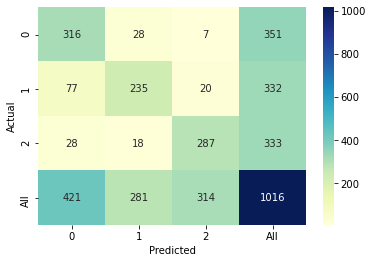

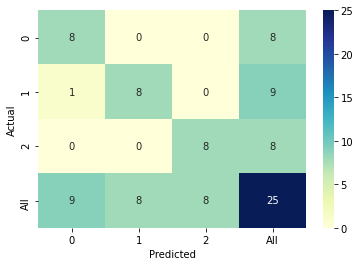

********************************
xgboost
Stride-based model performance (Macro):  0.8307086614173228 0.8351479831207561 0.8295464138837633 0.8295739450074904 0.9436132576471711
Stride-based model performance (Micro):  0.8307086614173228 0.8307086614173228 0.8307086614173228 0.8307086614173228 None
Stride-based model performance (Weighted):  0.8307086614173228 0.8340710149374363 0.8307086614173228 0.8295971419777599 0.9435863234972072
Stride-based model performance (Class-wise):  0.8307086614173228 [0.77419355 0.83216783 0.89908257] [0.88888889 0.71686747 0.88288288] [0.82758621 0.77022654 0.89090909] None
XGBClassifier(colsample_bytree=1.0, gamma=0.1, max_depth=7, min_child_weight=5,
              objective='multi:softprob', subsample=0.6)
Person-based model performance (Macro):  0.92 0.9259259259259259 0.9259259259259259 0.9191176470588237 1.0
Person-based model performance (Micro):  0.92 0.92 0.92 0.92 None
Person-based model performance (Weighted):  0.92 0.9288888888888889 0.92 0.91

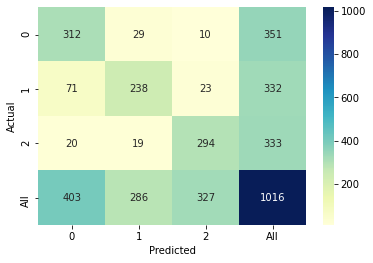

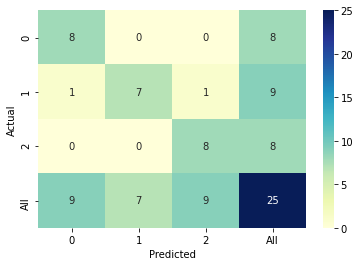

********************************
knn
Stride-based model performance (Macro):  0.7854330708661418 0.7932741690991237 0.7838567637764425 0.7839130471790073 0.8378925728323319
Stride-based model performance (Micro):  0.7854330708661418 0.7854330708661418 0.7854330708661418 0.7854330708661417 None
Stride-based model performance (Weighted):  0.7854330708661418 0.7919703334337731 0.7854330708661418 0.7840154409980052 0.8379713467814396
Stride-based model performance (Class-wise):  0.7854330708661418 [0.72037915 0.80586081 0.85358255] [0.86609687 0.6626506  0.82282282] [0.78654592 0.72727273 0.83792049] None
KNeighborsClassifier(n_neighbors=1)
Person-based model performance (Macro):  1.0 1.0 1.0 1.0 1.0
Person-based model performance (Micro):  1.0 1.0 1.0 1.0 None
Person-based model performance (Weighted):  1.0 1.0 1.0 1.0 1.0
Person-based model performance (Class-wise):  1.0 [1. 1. 1.] [1. 1. 1.] [1. 1. 1.] None


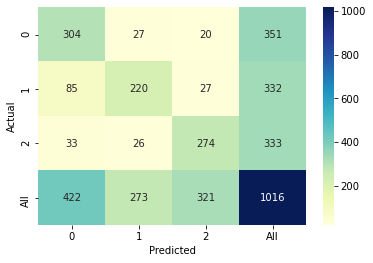

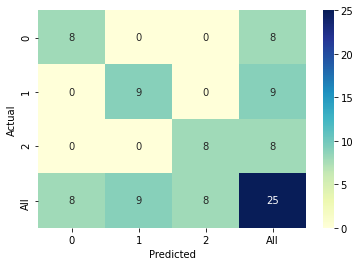

********************************
decision_tree
Stride-based model performance (Macro):  0.6515748031496063 0.6647908581388816 0.6505983895542129 0.6537988593674778 0.7947072806510557
Stride-based model performance (Micro):  0.6515748031496063 0.6515748031496063 0.6515748031496063 0.6515748031496063 None
Stride-based model performance (Weighted):  0.6515748031496063 0.6646087727272344 0.6515748031496063 0.6542426927304267 0.7946712558992881
Stride-based model performance (Class-wise):  0.6515748031496063 [0.64829396 0.55284553 0.79323308] [0.7037037  0.61445783 0.63363363] [0.67486339 0.58202568 0.70450751] None
DecisionTreeClassifier(min_samples_split=40, random_state=0)
Person-based model performance (Macro):  0.84 0.8592592592592593 0.8379629629629629 0.8409258440218194 0.9623842592592592
Person-based model performance (Micro):  0.84 0.84 0.84 0.8399999999999999 None
Person-based model performance (Weighted):  0.84 0.8568888888888889 0.84 0.8409730207872623 0.9619444444444445
Person-

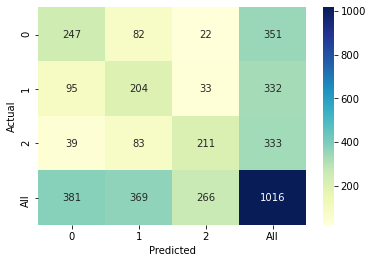

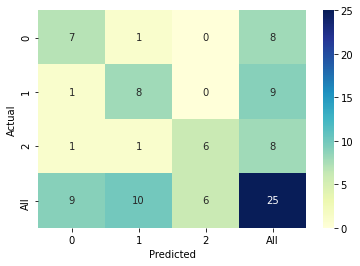

********************************
linear_svm
Stride-based model performance (Macro):  0.781496062992126 0.7836485569667411 0.779967486794796 0.7793771896313318 0.9051159034983222
Stride-based model performance (Micro):  0.781496062992126 0.781496062992126 0.781496062992126 0.781496062992126 None
Stride-based model performance (Weighted):  0.781496062992126 0.7830828838231156 0.781496062992126 0.779837246441348 0.9053154903547124
Stride-based model performance (Class-wise):  0.781496062992126 [0.75124378 0.77508651 0.82461538] [0.86039886 0.6746988  0.8048048 ] [0.80212483 0.72141707 0.81458967] None
LinearSVC(loss='hinge', random_state=0)
Person-based model performance (Macro):  0.96 0.9629629629629629 0.9629629629629629 0.9607843137254902 1.0
Person-based model performance (Micro):  0.96 0.96 0.96 0.96 None
Person-based model performance (Weighted):  0.96 0.9644444444444444 0.96 0.96 1.0
Person-based model performance (Class-wise):  0.96 [0.88888889 1.         1.        ] [1.         0

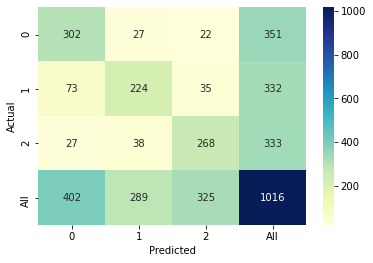

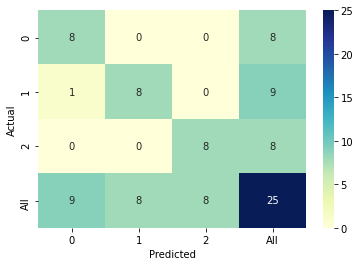

********************************
mlp
Stride-based model performance (Macro):  0.7549212598425197 0.7857293309043181 0.752523685254609 0.7551575380480043 0.9040743451720695
Stride-based model performance (Micro):  0.7549212598425197 0.7549212598425197 0.7549212598425197 0.7549212598425197 None
Stride-based model performance (Weighted):  0.7549212598425197 0.7835835684348642 0.7549212598425197 0.7552335084750825 0.9041423890613958
Stride-based model performance (Class-wise):  0.7549212598425197 [0.66311301 0.75873016 0.93534483] [0.88603989 0.71987952 0.65165165] [0.75853659 0.73879444 0.76814159] None
MLPClassifier(hidden_layer_sizes=(50, 50, 5, 10, 5, 200, 200, 10),
              learning_rate='adaptive', max_iter=500, random_state=0,
              shuffle=False)
Person-based model performance (Macro):  0.88 0.9090909090909092 0.8842592592592592 0.8834795321637428 0.9881365740740741
Person-based model performance (Micro):  0.88 0.88 0.88 0.88 None
Person-based model performance (Weight

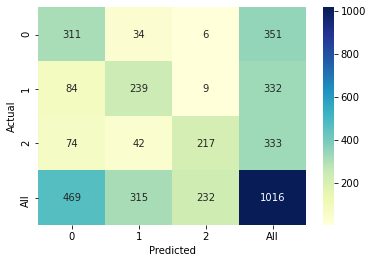

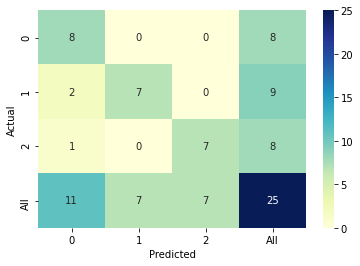

********************************


In [6]:
for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(trainX_norm, trainY, testX_norm, testY, ml_model, framework, results_path, save_results)  
    metrics[ml_model] = stride_person_metrics
    predicted_probs_person[ml_model+'_HOA'] = predict_probs_person[0]
    predicted_probs_person[ml_model+'_MS'] = predict_probs_person[1]
    predicted_probs_person[ml_model+'_PD'] = predict_probs_person[2]
    print ('********************************')

metrics.index = ['stride_accuracy', 'stride_precision_macro', 'stride_precision_micro', 'stride_precision_weighted', \
                 'stride_precision_class_wise', 'stride_recall_macro', 'stride_recall_micro', \
                 'stride_recall_weighted', 'stride_recall_class_wise', \
                 'stride_F1_macro', 'stride_F1_micro', 'stride_F1_weighted', 'stride_F1_class_wise', \
                 'stride_AUC_macro', 'stride_AUC_micro', 'stride_AUC_weighted',\
                 'stride_AUC_class_wise', 'person_accuracy', 'person_precision_macro', 'person_precision_micro', \
                 'person_precision_weighted', \
                 'person_precision_class_wise', 'person_recall_macro', 'person_recall_micro', \
                 'person_recall_weighted', 'person_recall_class_wise', \
                 'person_F1_macro', 'person_F1_micro', 'person_F1_weighted', 'person_F1_class_wise', \
                 'person_AUC_macro', 'person_AUC_micro', 'person_AUC_weighted', 'person_AUC_class_wise']  
if save_results:
    metrics.to_csv(results_path+ framework+ '\\task_generalize_'+framework+'_result_metrics.csv')
    predicted_probs_person.to_csv(results_path +framework+ '\\task_generalize_'+framework+'_prediction_probs.csv')

In [7]:
metrics

,logistic_regression,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,mlp
stride_accuracy,0.779528,0.586614,0.516732,0.645669,0.824803,0.830709,0.785433,0.651575,0.781496,0.754921
stride_precision_macro,0.783083,0.592785,0.531210,0.651957,0.833635,0.835148,0.793274,0.664791,0.783649,0.785729
stride_precision_micro,0.779528,0.586614,0.516732,0.645669,0.824803,0.830709,0.785433,0.651575,0.781496,0.754921
stride_precision_weighted,0.782304,0.591995,0.531758,0.651444,0.832161,0.834071,0.791970,0.664609,0.783083,0.783584
stride_precision_class_wise,"[0.7382716049382716, 0.7687074829931972, 0.842...","[0.5435294117647059, 0.5084745762711864, 0.726...","[0.5509708737864077, 0.32947976878612717, 0.71...","[0.6193029490616622, 0.5857142857142857, 0.750...","[0.7505938242280285, 0.8362989323843416, 0.914...","[0.7741935483870968, 0.8321678321678322, 0.899...","[0.7203791469194313, 0.8058608058608059, 0.853...","[0.6482939632545932, 0.5528455284552846, 0.793...","[0.7512437810945274, 0.7750865051903114, 0.824...","[0.6631130063965884, 0.7587301587301587, 0.935..."
stride_recall_macro,0.778126,0.585191,0.514217,0.645417,0.823326,0.829546,0.783857,0.650598,0.779967,0.752524
stride_recall_micro,0.779528,0.586614,0.516732,0.645669,0.824803,0.830709,0.785433,0.651575,0.781496,0.754921
stride_recall_weighted,0.779528,0.586614,0.516732,0.645669,0.824803,0.830709,0.785433,0.651575,0.781496,0.754921
stride_recall_class_wise,"[0.8518518518518519, 0.6807228915662651, 0.801...","[0.6581196581196581, 0.45180722891566266, 0.64...","[0.6467236467236467, 0.3433734939759036, 0.552...","[0.6581196581196581, 0.6174698795180723, 0.660...","[0.9002849002849003, 0.7078313253012049, 0.861...","[0.8888888888888888, 0.7168674698795181, 0.882...","[0.8660968660968661, 0.6626506024096386, 0.822...","[0.7037037037037037, 0.6144578313253012, 0.633...","[0.8603988603988604, 0.6746987951807228, 0.804...","[0.886039886039886, 0.7198795180722891, 0.6516..."
stride_F1_macro,0.778196,0.585818,0.517992,0.647390,0.824182,0.829574,0.783913,0.653799,0.779377,0.755158


<Figure size 432x288 with 0 Axes>

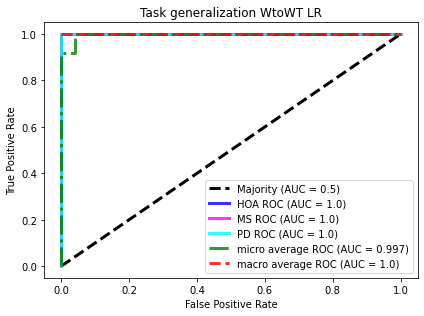

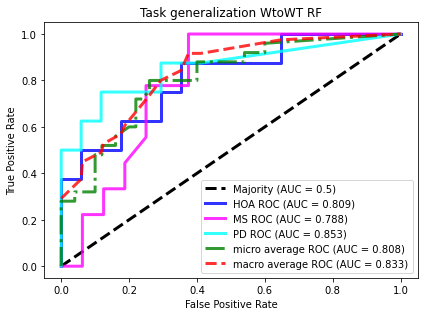

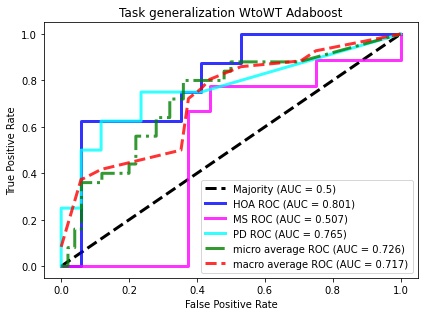

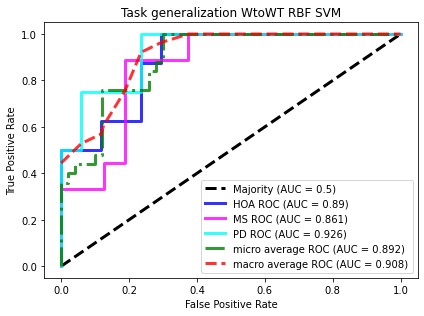

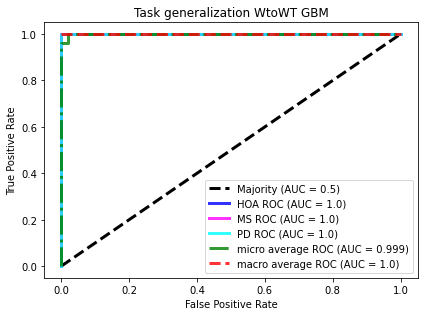

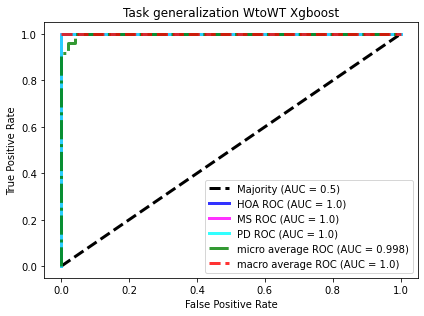

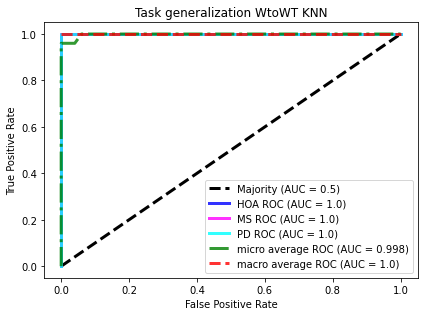

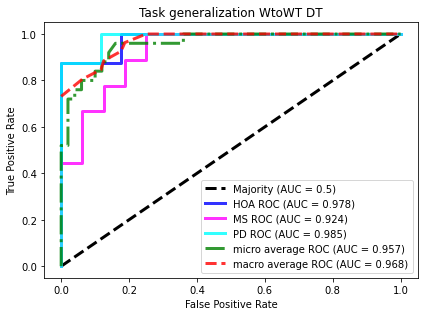

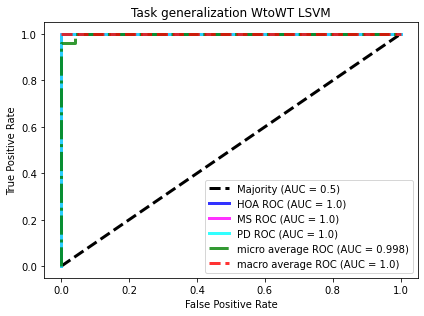

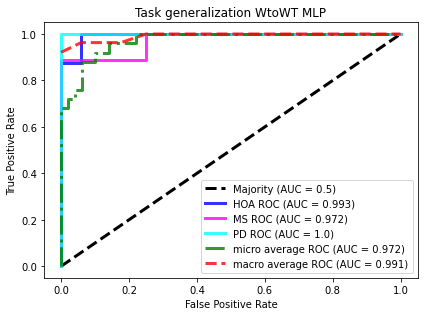

In [8]:
plot_ROC(ml_models, testY, predicted_probs_person, framework, results_path, save_results)

###  Task generalization framework 2: train on virtual beam walking (VBW) and test on virtual beam walking while talking (VBWT) with traditional ML algorithms to classify strides and subjects in HOA/MS/PD groups

In [9]:
#Trial VBW for training 
trialVBW = data[data['scenario']=='SLW']
#Trial VBWT for testing 
trialVBWT = data[data['scenario']=='SLWT']

#Trial VBW and VBWT after making sure both training and testing sets have common subjects 
trialVBW_reduced, trialVBWT_reduced = keep_subjects_common_across_train_test(trialVBW, trialVBWT)
# print ('Number of subjects in training and test sets after reduction:', len(trialW_reduced['PID'].unique()), \
#            len(trialWT_reduced['PID'].unique()))

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the training stride data
trialVBW_reduced = shuffle(trialVBW_reduced, random_state = 0)
trainX_VBW = trialVBW_reduced.drop(cols_to_drop, axis = 1)
trainY_VBW = trialVBW_reduced[['PID', 'label']]
print ('Training shape', trainX_VBW.shape, trainY_VBW.shape)

#Shuffling the testing stride data 
trialVBWT_reduced = shuffle(trialVBWT_reduced, random_state = 0)
testX_VBWT = trialVBWT_reduced.drop(cols_to_drop, axis = 1)
testY_VBWT = trialVBWT_reduced[['PID', 'label']] #PID to compute person based metrics later 
print ('Testing shape', testX_VBWT.shape, testY_VBWT.shape)

#Normalize according to z-score standardization
norm_mean_VB, norm_sd_VB = normalize(trainX_VBW, 'z')
trainX_norm_VBW = (trainX_VBW-norm_mean_VB)/norm_sd_VB
testX_norm_VBWT = (testX_VBWT-norm_mean_VB)/norm_sd_VB

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(trialVBW_reduced))
print ('HOA, MS and PD strides in training set:\n', trialVBW_reduced['cohort'].value_counts())

#Test Set
print('\nStrides in test set: ', len(trialVBWT_reduced)) 
print ('HOA, MS and PD strides in test set:\n', trialVBWT_reduced['cohort'].value_counts())
print ('Imbalance ratio (controls:MS:PD)= 1:X:Y\n', trialVBWT_reduced['cohort'].value_counts()/trialVBWT_reduced['cohort'].value_counts()['HOA'])

framework = 'VBWtoVBWT' #Defining the task generalization framework of interest

Original number of subjects in training and test sets: 22 21
Subjects in test set, which are not in training set
[]
Subjects in training set, which are not in test set
[323]
Number of subjects in training and test sets after reduction: 21 21
Training shape (789, 91) (789, 2)
Testing shape (837, 91) (837, 2)
Strides in training set:  789
HOA, MS and PD strides in training set:
 HOA    336
MS     243
PD     210
Name: cohort, dtype: int64

Strides in test set:  837
HOA, MS and PD strides in test set:
 HOA    341
MS     254
PD     242
Name: cohort, dtype: int64
Imbalance ratio (controls:MS:PD)= 1:X:Y
 HOA    1.000000
MS     0.744868
PD     0.709677
Name: cohort, dtype: float64


In [10]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_VB = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for classes HOA/MS/PD) to show ROC curves 
predicted_probs_person_VB = pd.DataFrame(columns = [ml_model + cohort for ml_model in ml_models for cohort in ['_HOA', '_MS', '_PD'] ]) 

random_forest
Stride-based model performance (Macro):  0.5615292712066906 0.5676411475974281 0.5586097425638377 0.5568947435388436 0.7469402734948721
Stride-based model performance (Micro):  0.5615292712066906 0.5615292712066906 0.5615292712066906 0.5615292712066906 None
Stride-based model performance (Weighted):  0.5615292712066906 0.5889076987245215 0.5615292712066906 0.5685992030397743 0.7517548615006785
Stride-based model performance (Class-wise):  0.5615292712066906 [0.7556391  0.5        0.44728435] [0.58944282 0.50787402 0.5785124 ] [0.66227348 0.50390625 0.5045045 ] None
RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_leaf=0.1,
                       n_estimators=45, random_state=0)
Person-based model performance (Macro):  0.6666666666666666 0.7005291005291004 0.6626984126984127 0.6666666666666666 0.8020833333333334
Person-based model performance (Micro):  0.6666666666666666 0.6666666666666666 0.6666666666666

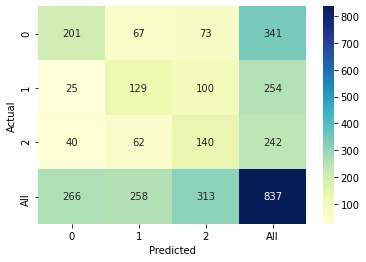

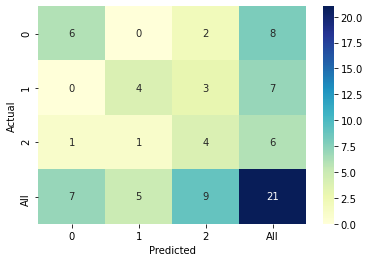

********************************
adaboost
Stride-based model performance (Macro):  0.5686977299880526 0.5483238144851418 0.548050878470903 0.5475108583475042 0.7786360843821111
Stride-based model performance (Micro):  0.5686977299880526 0.5686977299880526 0.5686977299880526 0.5686977299880526 None
Stride-based model performance (Weighted):  0.5686977299880526 0.5627243230448737 0.5686977299880526 0.5650013837058137 0.7835435807822748
Stride-based model performance (Class-wise):  0.5686977299880526 [0.68206522 0.44939271 0.51351351] [0.73607038 0.43700787 0.47107438] [0.70803949 0.44311377 0.49137931] None
AdaBoostClassifier(learning_rate=0.1, random_state=0)
Person-based model performance (Macro):  0.6666666666666666 0.6738095238095237 0.6567460317460317 0.6462056462056461 0.8526785714285715
Person-based model performance (Micro):  0.6666666666666666 0.6666666666666666 0.6666666666666666 0.6666666666666666 None
Person-based model performance (Weighted):  0.6666666666666666 0.6799319727

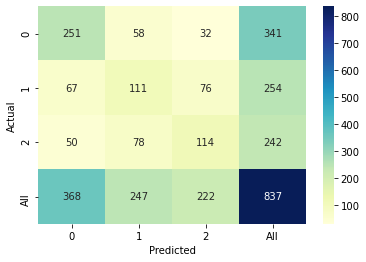

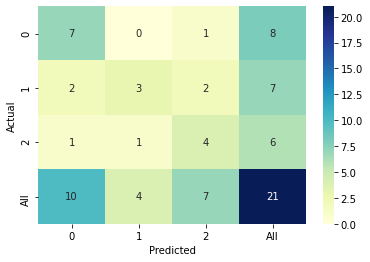

********************************
kernel_svm
Stride-based model performance (Macro):  0.4074074074074074 0.13580246913580246 0.3333333333333333 0.19298245614035084 0.19222750732628935
Stride-based model performance (Micro):  0.4074074074074074 0.4074074074074074 0.4074074074074074 0.4074074074074074 None
Stride-based model performance (Weighted):  0.4074074074074074 0.16598079561042522 0.4074074074074074 0.23586744639376217 0.19122978147291247
Stride-based model performance (Class-wise):  0.4074074074074074 [0.40740741 0.         0.        ] [1. 0. 0.] [0.57894737 0.         0.        ] None
SVC(gamma=1, probability=True, random_state=0)
Person-based model performance (Macro):  0.38095238095238093 0.12698412698412698 0.3333333333333333 0.1839080459770115 0.5
Person-based model performance (Micro):  0.38095238095238093 0.38095238095238093 0.38095238095238093 0.38095238095238093 None
Person-based model performance (Weighted):  0.38095238095238093 0.14512471655328799 0.38095238095238093 0.

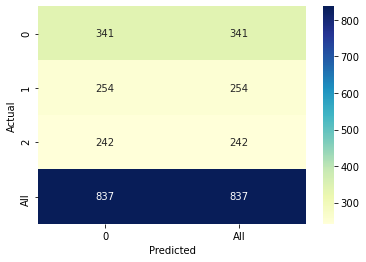

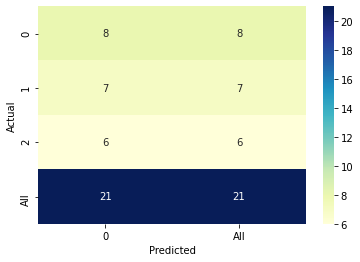

********************************
gbm
Stride-based model performance (Macro):  0.7777777777777778 0.774643894504473 0.7796514105424905 0.7752401099868601 0.9245365397192101
Stride-based model performance (Micro):  0.7777777777777778 0.7777777777777778 0.7777777777777778 0.7777777777777778 None
Stride-based model performance (Weighted):  0.7777777777777778 0.7837649108648332 0.7777777777777778 0.7787283934569561 0.9246364169584881
Stride-based model performance (Class-wise):  0.7777777777777778 [0.85761589 0.72631579 0.74      ] [0.75953079 0.81496063 0.76446281] [0.80559876 0.76808905 0.75203252] None
GradientBoostingClassifier(max_depth=7, max_features=4, min_samples_split=4,
                           random_state=0)
Person-based model performance (Macro):  0.9523809523809523 0.9583333333333334 0.9583333333333334 0.9555555555555556 0.9965277777777777
Person-based model performance (Micro):  0.9523809523809523 0.9523809523809523 0.9523809523809523 0.9523809523809523 None
Person-based m

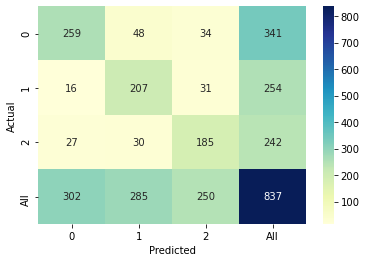

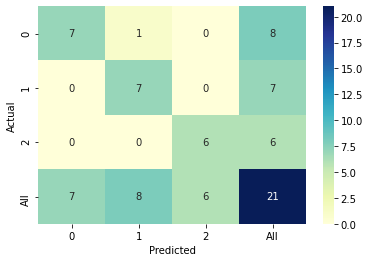

********************************
xgboost
Stride-based model performance (Macro):  0.7550776583034647 0.7519925619569747 0.7568655357696391 0.7521651028967558 0.9126239127133902
Stride-based model performance (Micro):  0.7550776583034647 0.7550776583034647 0.7550776583034647 0.7550776583034647 None
Stride-based model performance (Weighted):  0.7550776583034647 0.7630655911335511 0.7550776583034647 0.7566114432776215 0.9140077022242574
Stride-based model performance (Class-wise):  0.7550776583034647 [0.85135135 0.70462633 0.7       ] [0.73900293 0.77952756 0.75206612] [0.79120879 0.74018692 0.7250996 ] None
XGBClassifier(colsample_bytree=1.0, gamma=1, max_depth=5,
              objective='multi:softprob', subsample=1.0)
Person-based model performance (Macro):  0.9523809523809523 0.9583333333333334 0.9583333333333334 0.9555555555555556 1.0
Person-based model performance (Micro):  0.9523809523809523 0.9523809523809523 0.9523809523809523 0.9523809523809523 None
Person-based model performanc

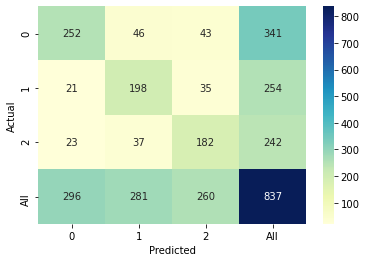

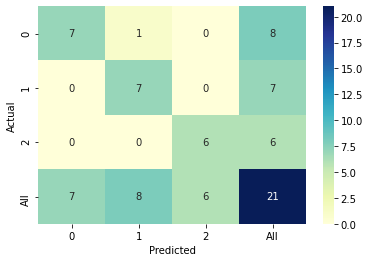

********************************
knn
Stride-based model performance (Macro):  0.7168458781362007 0.7178212993731923 0.7047621946483562 0.7082139234397927 0.8759436002781347
Stride-based model performance (Micro):  0.7168458781362007 0.7168458781362007 0.7168458781362007 0.7168458781362007 None
Stride-based model performance (Weighted):  0.7168458781362007 0.7176335893175338 0.7168458781362007 0.7142665220705205 0.8767332110653834
Stride-based model performance (Class-wise):  0.7168458781362007 [0.71801567 0.703125   0.73232323] [0.80645161 0.70866142 0.59917355] [0.75966851 0.70588235 0.65909091] None
KNeighborsClassifier(n_neighbors=10, p=1)
Person-based model performance (Macro):  0.9047619047619048 0.9333333333333332 0.8888888888888888 0.8962962962962964 0.9781746031746031
Person-based model performance (Micro):  0.9047619047619048 0.9047619047619048 0.9047619047619048 0.9047619047619048 None
Person-based model performance (Weighted):  0.9047619047619048 0.9238095238095237 0.9047619

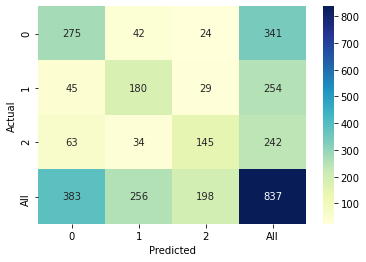

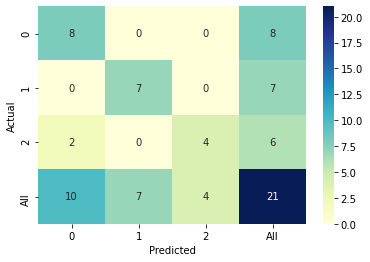

********************************
decision_tree
Stride-based model performance (Macro):  0.6021505376344086 0.5954607298306788 0.5942541306570216 0.5945496160455322 0.6976308186901372
Stride-based model performance (Micro):  0.6021505376344086 0.6021505376344086 0.6021505376344086 0.6021505376344086 None
Stride-based model performance (Weighted):  0.6021505376344086 0.6058272943617034 0.6021505376344086 0.6036828407339899 0.6996062179854544
Stride-based model performance (Class-wise):  0.6021505376344086 [0.69512195 0.49632353 0.59493671] [0.6686217  0.53149606 0.58264463] [0.68161435 0.51330798 0.58872651] None
DecisionTreeClassifier(min_samples_split=3, random_state=0)
Person-based model performance (Macro):  0.8571428571428571 0.851851851851852 0.8492063492063493 0.8479135243841126 0.9345238095238096
Person-based model performance (Micro):  0.8571428571428571 0.8571428571428571 0.8571428571428571 0.8571428571428571 None
Person-based model performance (Weighted):  0.8571428571428571 0

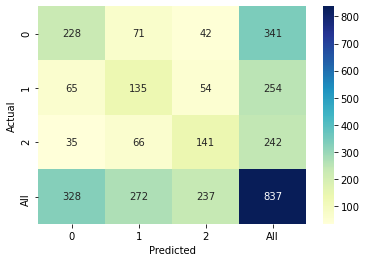

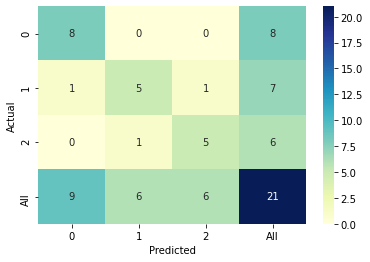

********************************
linear_svm
Stride-based model performance (Macro):  0.7048984468339307 0.700635943226013 0.6962706707782562 0.6942110313881978 0.8582652993004459
Stride-based model performance (Micro):  0.7048984468339307 0.7048984468339307 0.7048984468339307 0.7048984468339307 None
Stride-based model performance (Weighted):  0.7048984468339307 0.7155879538871727 0.7048984468339307 0.7062337575445811 0.8614862551170248
Stride-based model performance (Class-wise):  0.7048984468339307 [0.83870968 0.60443038 0.65876777] [0.76246334 0.7519685  0.57438017] [0.79877112 0.67017544 0.61368653] None
LinearSVC(random_state=0)
Person-based model performance (Macro):  0.9047619047619048 0.8968253968253969 0.8968253968253969 0.8968253968253969 0.9503968253968255
Person-based model performance (Micro):  0.9047619047619048 0.9047619047619048 0.9047619047619048 0.9047619047619048 None
Person-based model performance (Weighted):  0.9047619047619048 0.9047619047619048 0.9047619047619048 

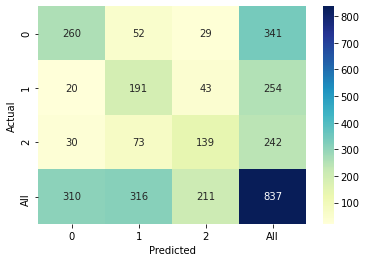

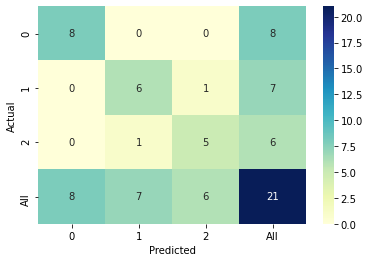

********************************
logistic_regression
Stride-based model performance (Macro):  0.7037037037037037 0.6999598593331413 0.6954978235025341 0.6928347822915285 0.8622878089107043
Stride-based model performance (Micro):  0.7037037037037037 0.7037037037037037 0.7037037037037037 0.7037037037037037 None
Stride-based model performance (Weighted):  0.7037037037037037 0.7155242324489282 0.7037037037037037 0.7049589259156855 0.865419962178234
Stride-based model performance (Class-wise):  0.7037037037037037 [0.84313725 0.60436137 0.65238095] [0.75659824 0.76377953 0.5661157 ] [0.79752705 0.67478261 0.60619469] None
LogisticRegression(random_state=0)
Person-based model performance (Macro):  0.9047619047619048 0.9259259259259259 0.9027777777777778 0.905808080808081 0.9692460317460317
Person-based model performance (Micro):  0.9047619047619048 0.9047619047619048 0.9047619047619048 0.9047619047619048 None
Person-based model performance (Weighted):  0.9047619047619048 0.9259259259259258 0.

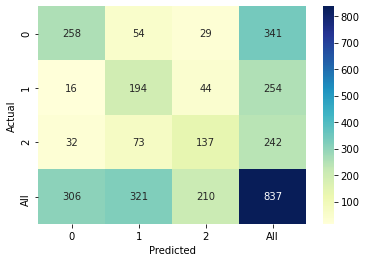

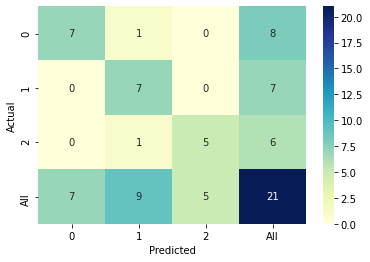

********************************
mlp
Stride-based model performance (Macro):  0.7096774193548387 0.7241783526681403 0.7040768131123039 0.7114156127341077 0.866161300754858
Stride-based model performance (Micro):  0.7096774193548387 0.7096774193548387 0.7096774193548387 0.7096774193548389 None
Stride-based model performance (Weighted):  0.7096774193548387 0.716349607329913 0.7096774193548387 0.7102585815031722 0.8626894927694098
Stride-based model performance (Class-wise):  0.7096774193548387 [0.65984655 0.70886076 0.80382775] [0.75659824 0.66141732 0.69421488] [0.70491803 0.68431772 0.74501109] None
MLPClassifier(hidden_layer_sizes=(50, 50, 50, 10, 50, 150, 30, 150, 5),
              learning_rate='adaptive', max_iter=500, random_state=0,
              shuffle=False)
Person-based model performance (Macro):  0.8571428571428571 0.9090909090909092 0.8492063492063493 0.8615098351940458 0.9970238095238096
Person-based model performance (Micro):  0.8571428571428571 0.8571428571428571 0.85714

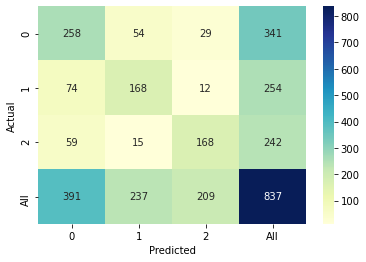

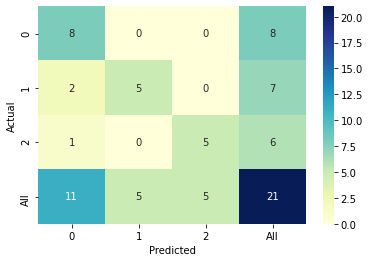

********************************


In [11]:
for ml_model in ml_models:
    print (ml_model)
    predict_probs_person_VB, stride_person_metrics_VB = models(trainX_norm_VBW, trainY_VBW, testX_norm_VBWT, testY_VBWT, ml_model, \
                                                              framework, results_path, save_results)
    metrics_VB[ml_model] = stride_person_metrics_VB
    predicted_probs_person_VB[ml_model+'_HOA'] = predict_probs_person_VB[0]
    predicted_probs_person_VB[ml_model+'_MS'] = predict_probs_person_VB[1]
    predicted_probs_person_VB[ml_model+'_PD'] = predict_probs_person_VB[2]
    print ('********************************')

metrics_VB.index = ['stride_accuracy', 'stride_precision_macro', 'stride_precision_micro', 'stride_precision_weighted', \
                 'stride_precision_class_wise', 'stride_recall_macro', 'stride_recall_micro', \
                 'stride_recall_weighted', 'stride_recall_class_wise', \
                 'stride_F1_macro', 'stride_F1_micro', 'stride_F1_weighted', 'stride_F1_class_wise', \
                 'stride_AUC_macro', 'stride_AUC_micro', 'stride_AUC_weighted',\
                 'stride_AUC_class_wise', 'person_accuracy', 'person_precision_macro', 'person_precision_micro', \
                 'person_precision_weighted', \
                 'person_precision_class_wise', 'person_recall_macro', 'person_recall_micro', \
                 'person_recall_weighted', 'person_recall_class_wise', \
                 'person_F1_macro', 'person_F1_micro', 'person_F1_weighted', 'person_F1_class_wise', \
                 'person_AUC_macro', 'person_AUC_micro', 'person_AUC_weighted', 'person_AUC_class_wise']  
if save_results:
    metrics_VB.to_csv(results_path+ framework+ '\\task_generalize_'+framework+'_result_metrics.csv')
    predicted_probs_person_VB.to_csv(results_path+framework+'\\task_generalize_'+framework+'_prediction_probs.csv')

In [12]:
metrics_VB

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
stride_accuracy,0.561529,0.568698,0.407407,0.777778,0.755078,0.716846,0.602151,0.704898,0.703704,0.709677
stride_precision_macro,0.567641,0.548324,0.135802,0.774644,0.751993,0.717821,0.595461,0.700636,0.699960,0.724178
stride_precision_micro,0.561529,0.568698,0.407407,0.777778,0.755078,0.716846,0.602151,0.704898,0.703704,0.709677
stride_precision_weighted,0.588908,0.562724,0.165981,0.783765,0.763066,0.717634,0.605827,0.715588,0.715524,0.716350
stride_precision_class_wise,"[0.7556390977443609, 0.5, 0.4472843450479233]","[0.6820652173913043, 0.4493927125506073, 0.513...","[0.4074074074074074, 0.0, 0.0]","[0.8576158940397351, 0.7263157894736842, 0.74]","[0.8513513513513513, 0.7046263345195729, 0.7]","[0.7180156657963447, 0.703125, 0.7323232323232...","[0.6951219512195121, 0.4963235294117647, 0.594...","[0.8387096774193549, 0.6044303797468354, 0.658...","[0.8431372549019608, 0.6043613707165109, 0.652...","[0.659846547314578, 0.7088607594936709, 0.8038..."
stride_recall_macro,0.558610,0.548051,0.333333,0.779651,0.756866,0.704762,0.594254,0.696271,0.695498,0.704077
stride_recall_micro,0.561529,0.568698,0.407407,0.777778,0.755078,0.716846,0.602151,0.704898,0.703704,0.709677
stride_recall_weighted,0.561529,0.568698,0.407407,0.777778,0.755078,0.716846,0.602151,0.704898,0.703704,0.709677
stride_recall_class_wise,"[0.5894428152492669, 0.5078740157480315, 0.578...","[0.7360703812316716, 0.43700787401574803, 0.47...","[1.0, 0.0, 0.0]","[0.7595307917888563, 0.8149606299212598, 0.764...","[0.7390029325513197, 0.7795275590551181, 0.752...","[0.8064516129032258, 0.7086614173228346, 0.599...","[0.6686217008797654, 0.531496062992126, 0.5826...","[0.7624633431085044, 0.7519685039370079, 0.574...","[0.7565982404692082, 0.7637795275590551, 0.566...","[0.7565982404692082, 0.6614173228346457, 0.694..."
stride_F1_macro,0.556895,0.547511,0.192982,0.775240,0.752165,0.708214,0.594550,0.694211,0.692835,0.711416


<Figure size 432x288 with 0 Axes>

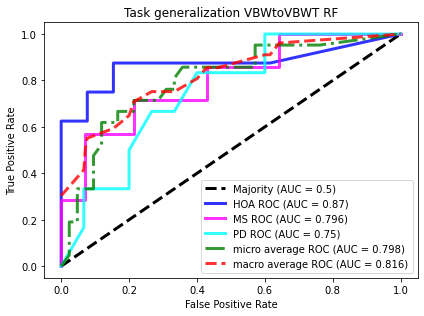

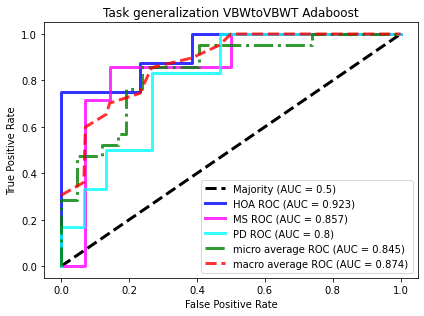

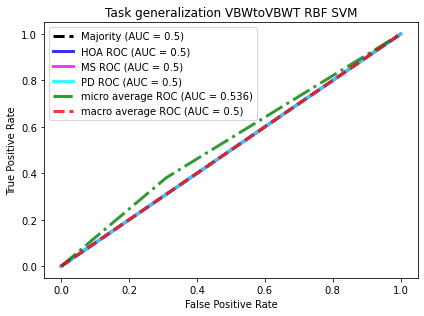

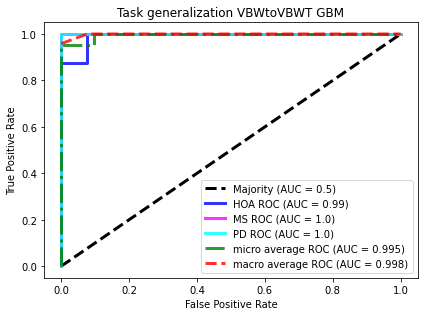

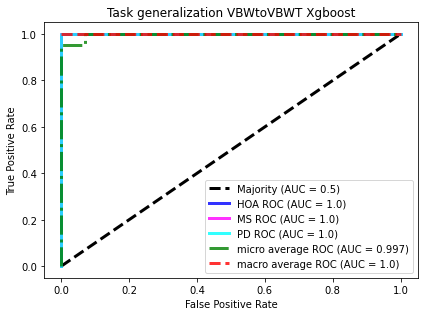

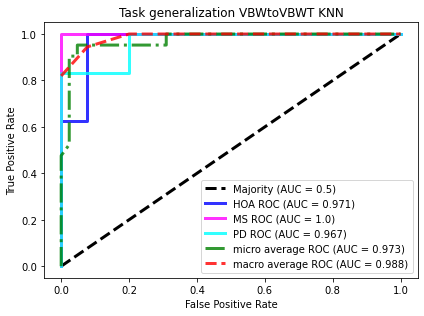

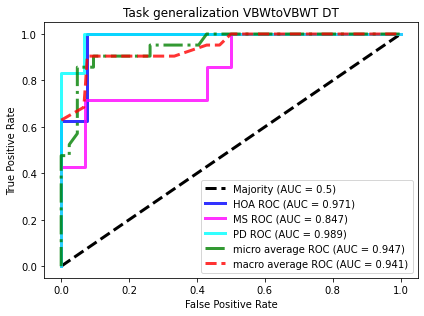

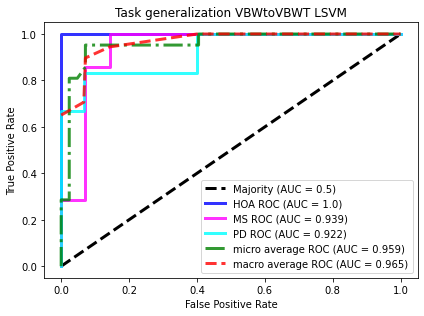

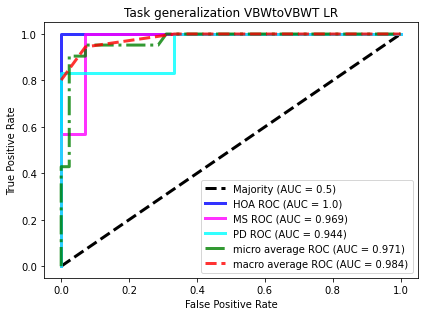

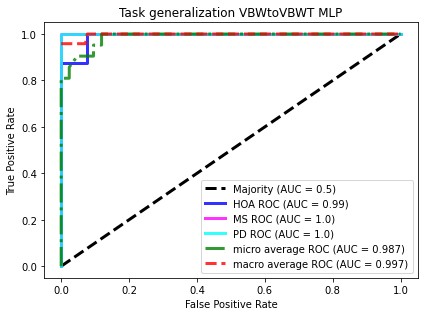

In [13]:
#ROC 
plot_ROC(ml_models, testY_VBWT, predicted_probs_person_VB, framework, results_path, save_results)

In [14]:
#Confusion matrices - Done
#micro/macro/weighted metric scores 
#Why is AUC 1 for low accuracy